In [1]:
import sys
import os

import joblib
import numpy as np
import pandas as pd

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, train_val_split, get_dimensions, scale, metrics_r, get_device, \
    plot_history, load_best_params, plot_mlp_comparison, d_types_methods, get_color_map, evaluate, \
    plot_prediction_scores, get_result_subsets, print_top_1, plot_true_vs_pred, get_results_table

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, predict, activation_funcs, predict_mc

## Settings

In [5]:
# Current Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
# Data Path
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

# Model Path
path_models = os.path.abspath(os.path.join(os.getcwd(), "models"))

In [7]:
# Targets
targets = ["StartYear", "YearRange"]

In [8]:
# Evaluation Metrics
criterion = nn.MSELoss()
metrics = metrics_r

## Data

### Read Features and Targets

In [9]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


### Train-Validation Split

In [10]:
X, y = train_val_split(X, y)

### Get Dimensions

In [11]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


### Torch Datasets and Dataloaders

In [12]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Best Params from Tuning

In [13]:
# Load Saved Best Params
path_params = "best_params.json"
best_params = load_best_params(path_params)

## Target Scaler

In [14]:
y_scaler = joblib.load("y_scaler.pkl")

## Text Input MLP Model

### Rebuild Model

In [15]:
ft = "tfidf"
params = best_params[ft]["params"]
pd.Series(params, name="value")

activation                 relu
blocks                        2
dropout                    0.05
hidden_size                 256
hidden_size_pattern    constant
lr                         0.01
Name: value, dtype: object

In [16]:
model_txt = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="years"
)

model_txt.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --                        --
│    └─Linear

### Load Weights

In [17]:
path_model = os.path.join(path_models, f"pottery_chronology_predictor_{ft}.pt")
model_txt.load_state_dict(torch.load(path_model, weights_only=True))
model_txt.eval()

print(f"✅ Loaded {ft.upper()}-Input Model. Ready for testing!")

✅ Loaded TFIDF-Input Model. Ready for testing!


### Predict Test Set

In [18]:
y_pred, y_std = predict_mc(model_txt, loaders["test"][ft], y_scaler, mc_samples=50)

[Test]: 100%|██████████| 3/3 [00:00<00:00, 69.59it/s]





TARGET: StartYear




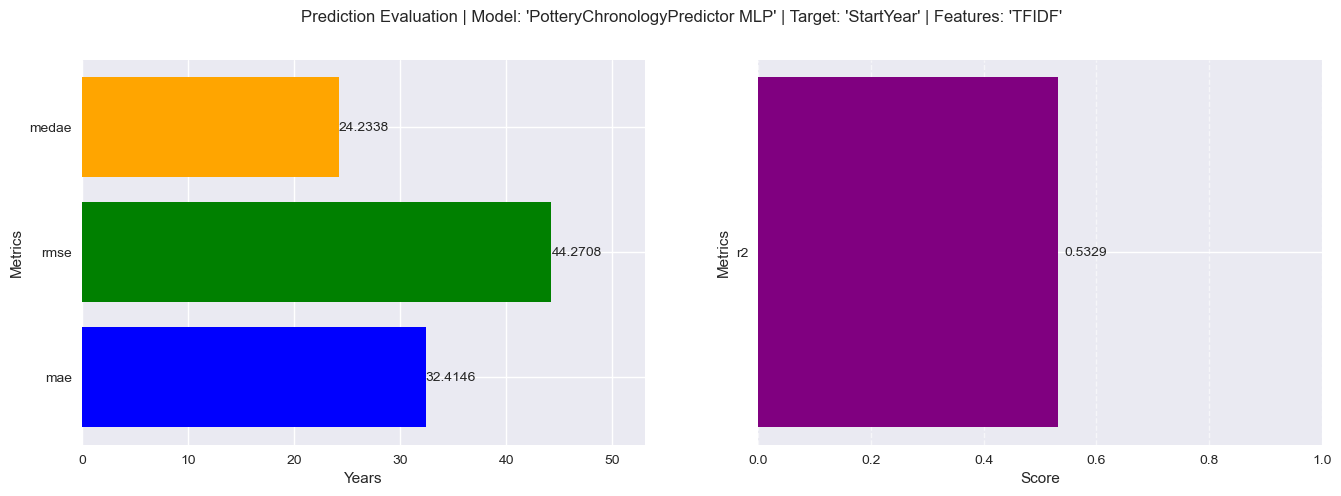



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,-400.0,-384.334930,6.322817,-396.727651,-371.942209,15.665070
144,BEST,-490.0,-489.654358,5.629801,-500.688767,-478.619949,0.345642
159,WORST,-350.0,-515.324402,9.825220,-534.581834,-496.066970,165.324402


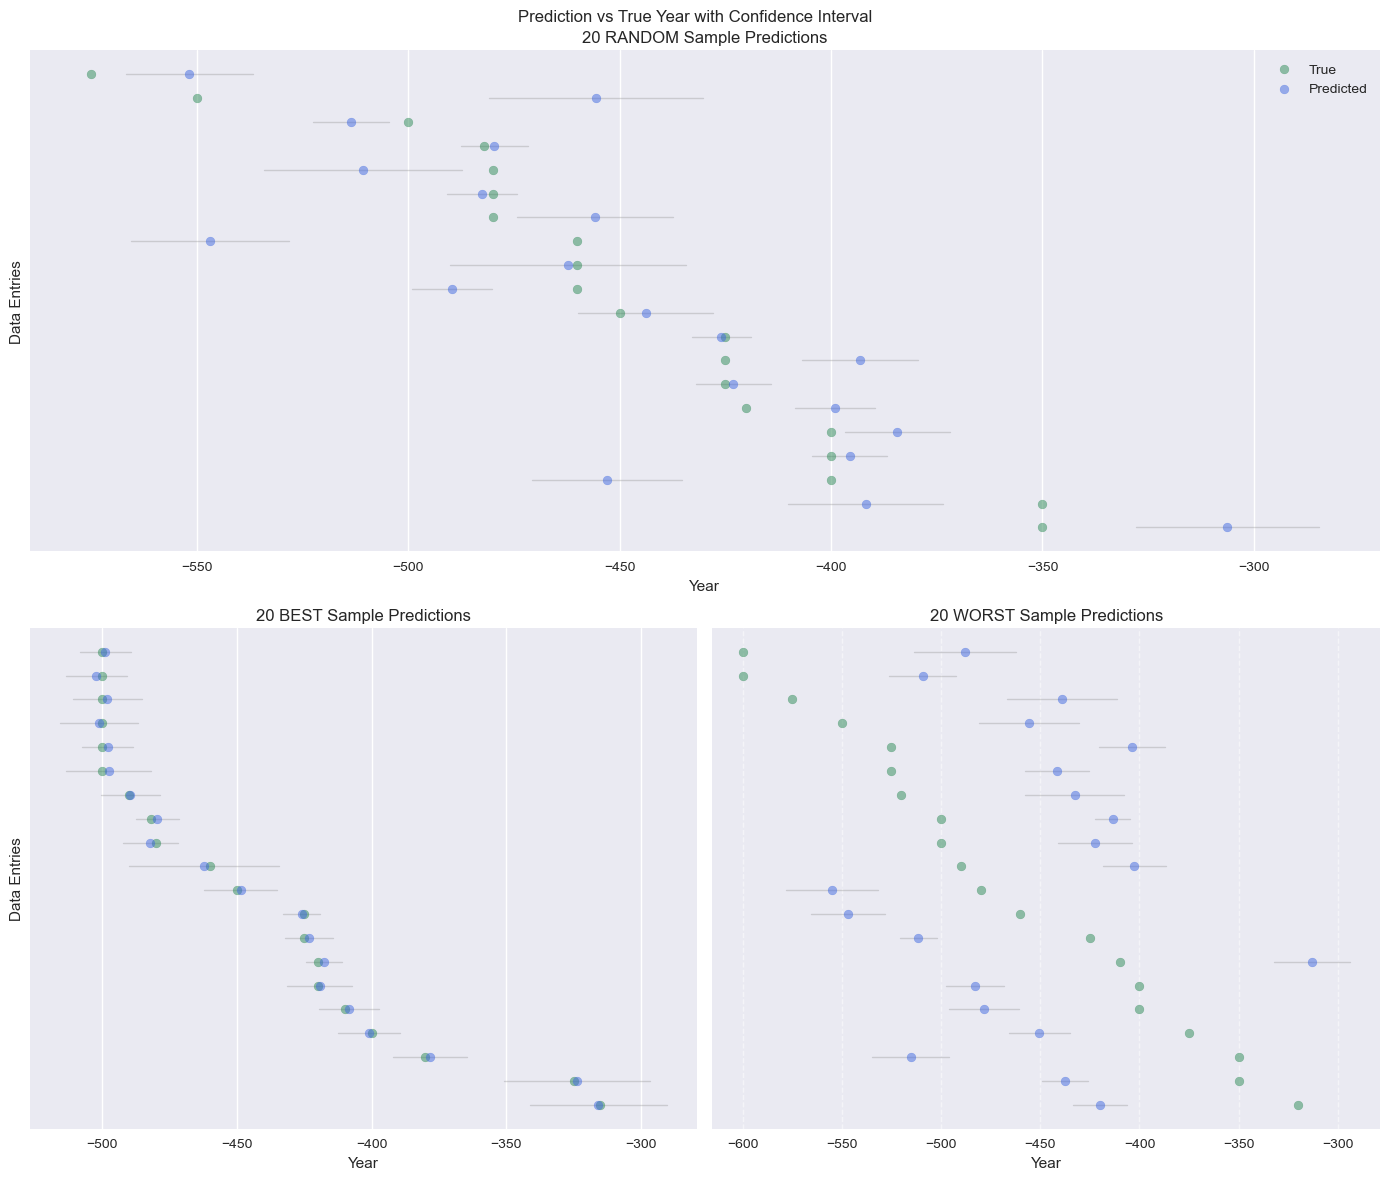




TARGET: YearRange




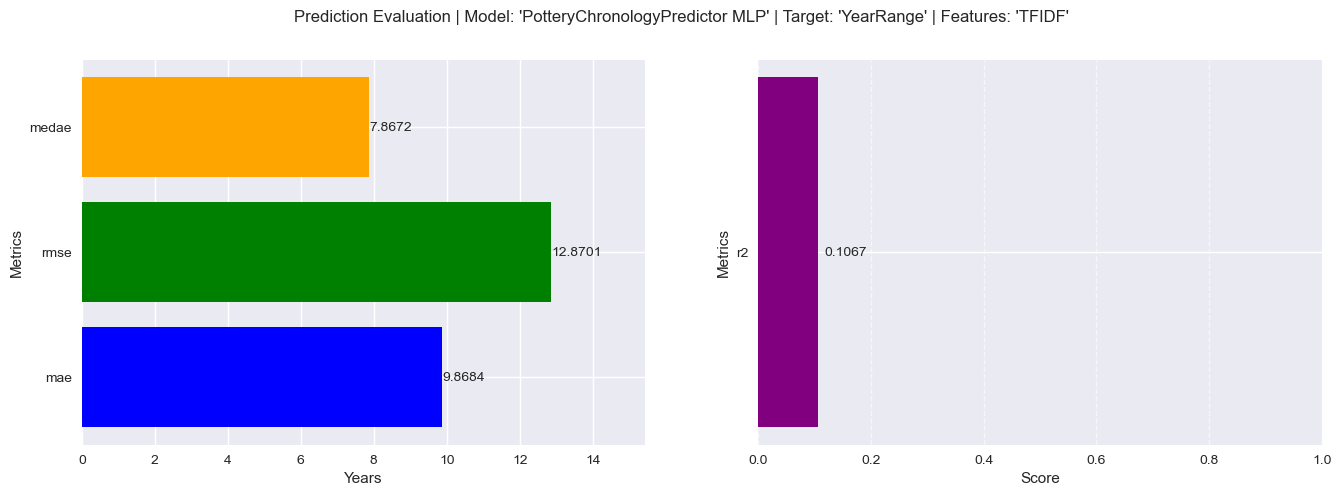



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,50.0,25.555380,1.220543,23.163115,27.947645,24.444620
138,BEST,0.0,-0.071486,1.132721,-2.291619,2.148648,0.071486
70,WORST,50.0,15.602450,2.198872,11.292661,19.912240,34.397550


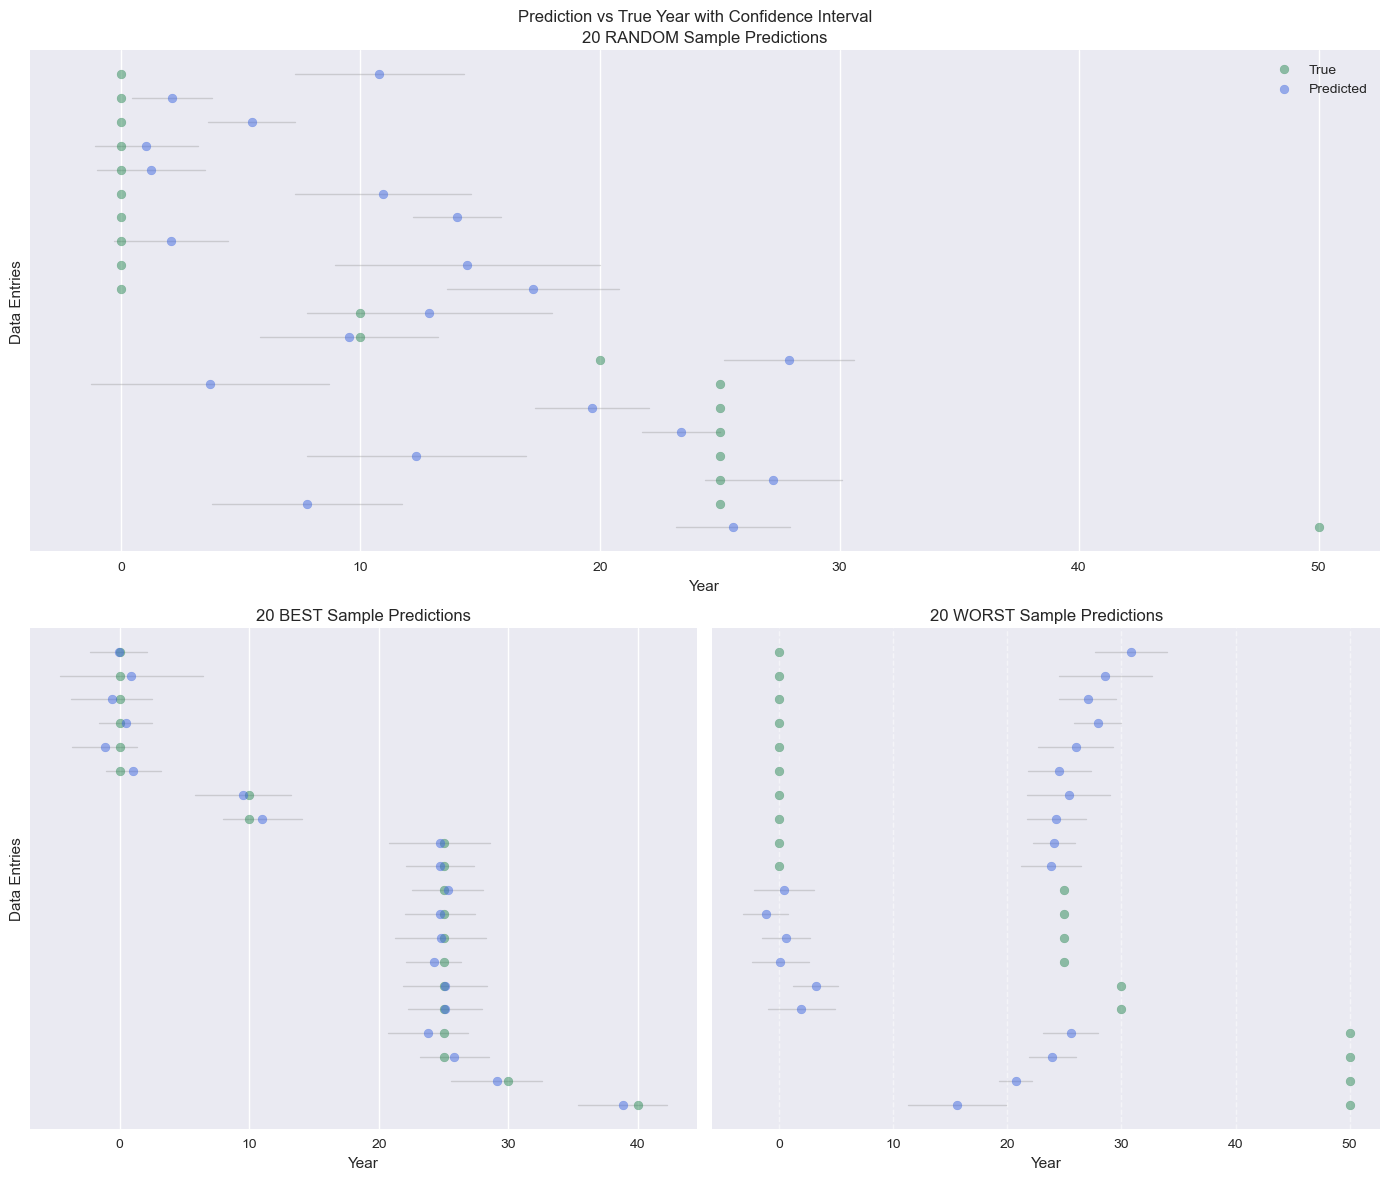

In [19]:
for t, target in enumerate(targets):
    print(f"\n\n\nTARGET: {target}")

    results = get_results_table(y["test"][:, t], y_pred[:, t], y_std[:, t])

    # Evaluate
    scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
    plot_prediction_scores(scores, "PotteryChronologyPredictor MLP", target, ft)

    # Predictions Close Look
    result_subsets = get_result_subsets(results, samples=20)
    print_top_1(result_subsets)
    plot_true_vs_pred(result_subsets)

## Image Input MLP Model

### Rebuild Model

In [20]:
ft = "vit"
params = best_params[ft]["params"]
pd.Series(params, name="value")

activation                   gelu
blocks                          3
dropout                       0.1
hidden_size                    64
hidden_size_pattern    decreasing
lr                          0.005
Name: value, dtype: object

In [21]:
model_img = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="years"
)

model_txt.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --                        --
│    └─Linear

### Load Weights

In [22]:
path_model = os.path.join(path_models, f"pottery_chronology_predictor_{ft}.pt")
model_img.load_state_dict(torch.load(path_model, weights_only=True))
model_img.eval()

print(f"✅ Loaded {ft.upper()}-Input Model. Ready for testing!")

✅ Loaded VIT-Input Model. Ready for testing!


### Predict Test Set

In [23]:
y_pred, y_std = predict_mc(model_img, loaders["test"][ft], y_scaler, mc_samples=50)

[Test]: 100%|██████████| 3/3 [00:00<00:00, 49.34it/s]





TARGET: StartYear




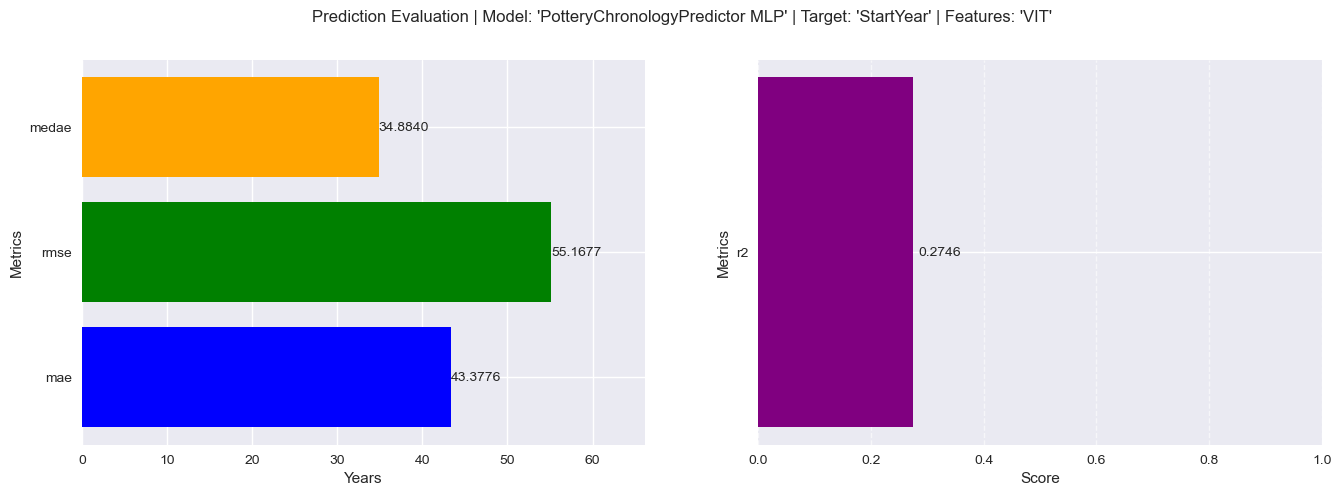



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,-400.0,-410.892822,9.474458,-429.462760,-392.322885,10.892822
5,BEST,-500.0,-500.267456,18.841650,-537.197090,-463.337823,0.267456
20,WORST,-600.0,-445.174469,1.458931,-448.033973,-442.314965,154.825531


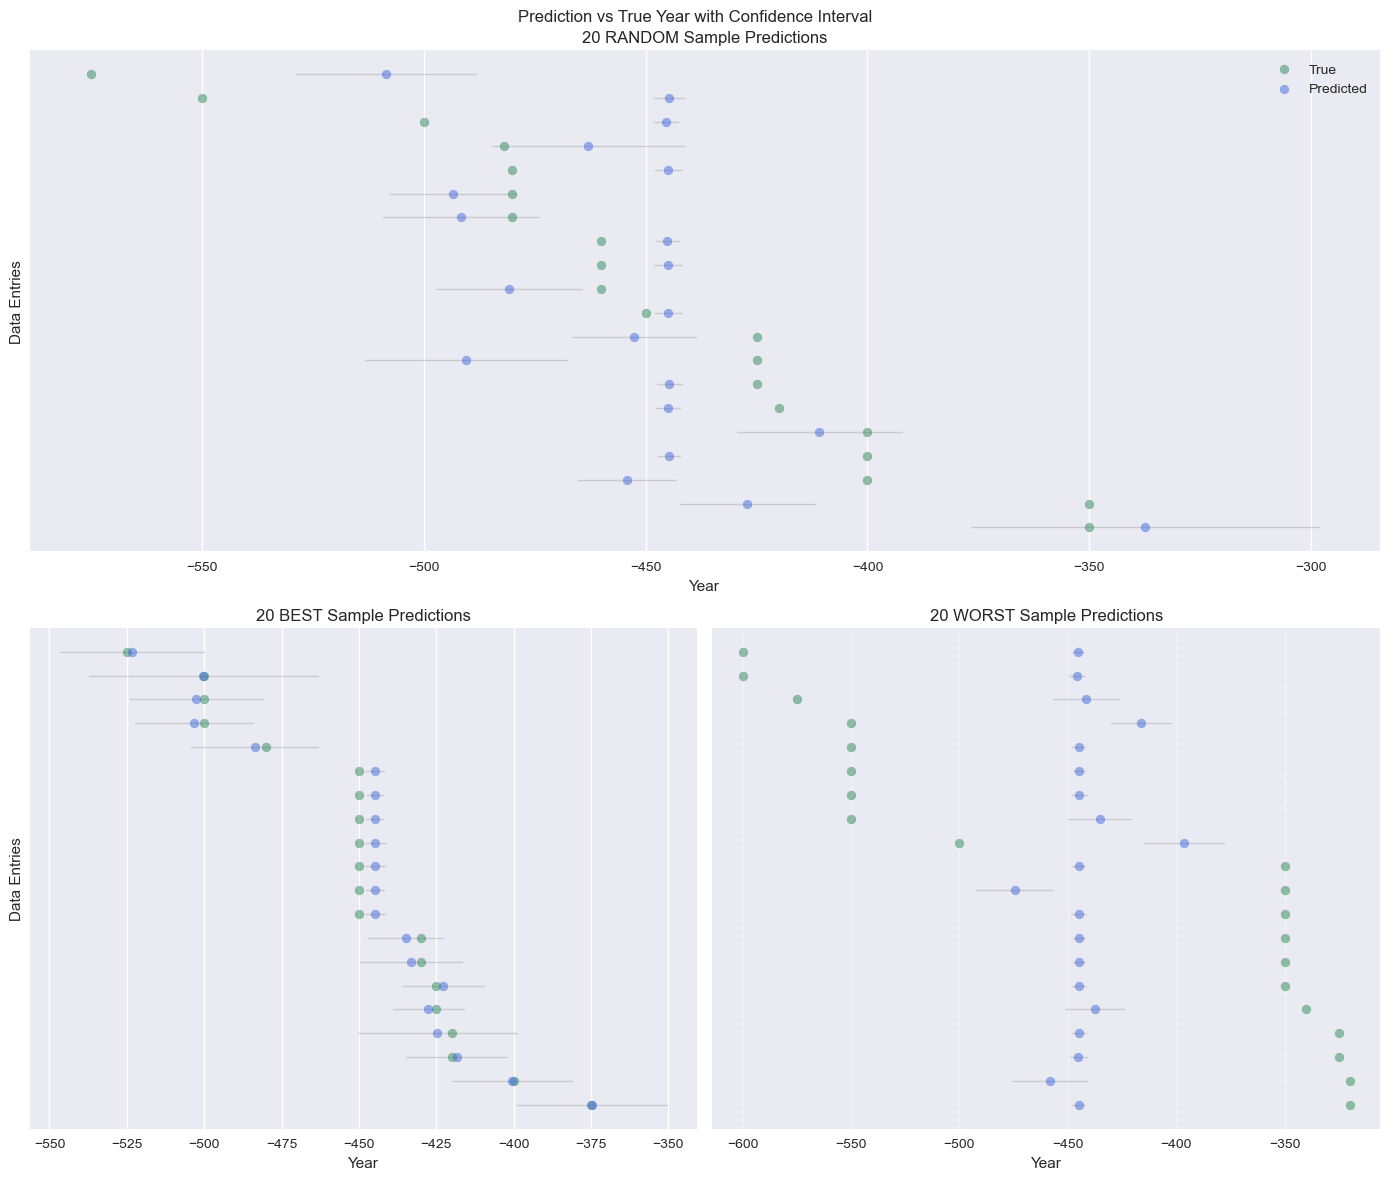




TARGET: YearRange




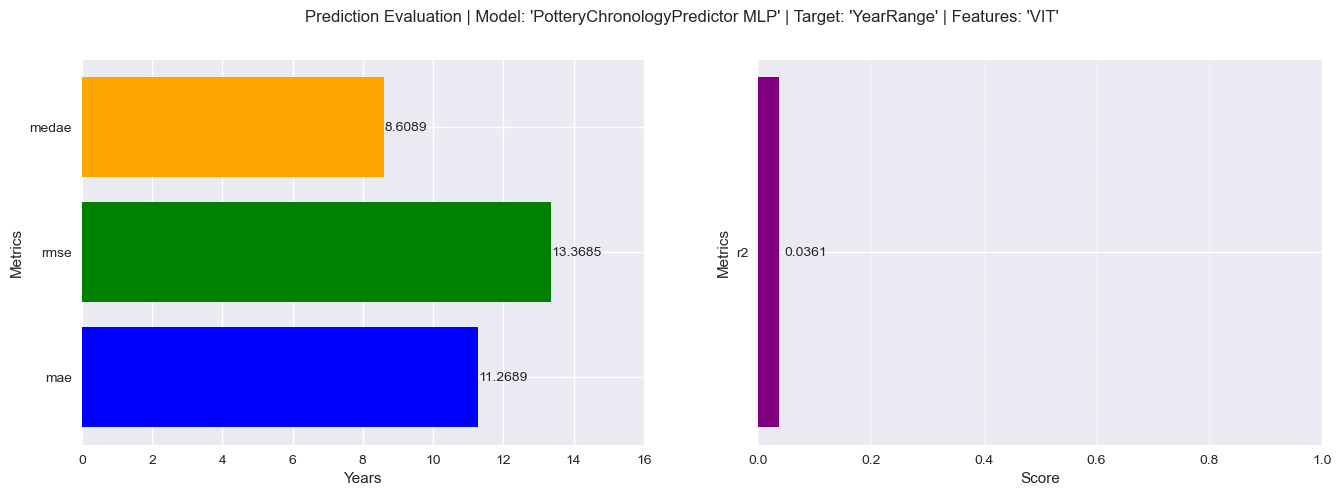



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,50.0,21.532337,1.259975,19.062787,24.001888,28.467663
166,BEST,0.0,0.197399,3.637278,-6.931667,7.326464,0.197399
159,WORST,50.0,16.473345,0.211356,16.059088,16.887602,33.526655


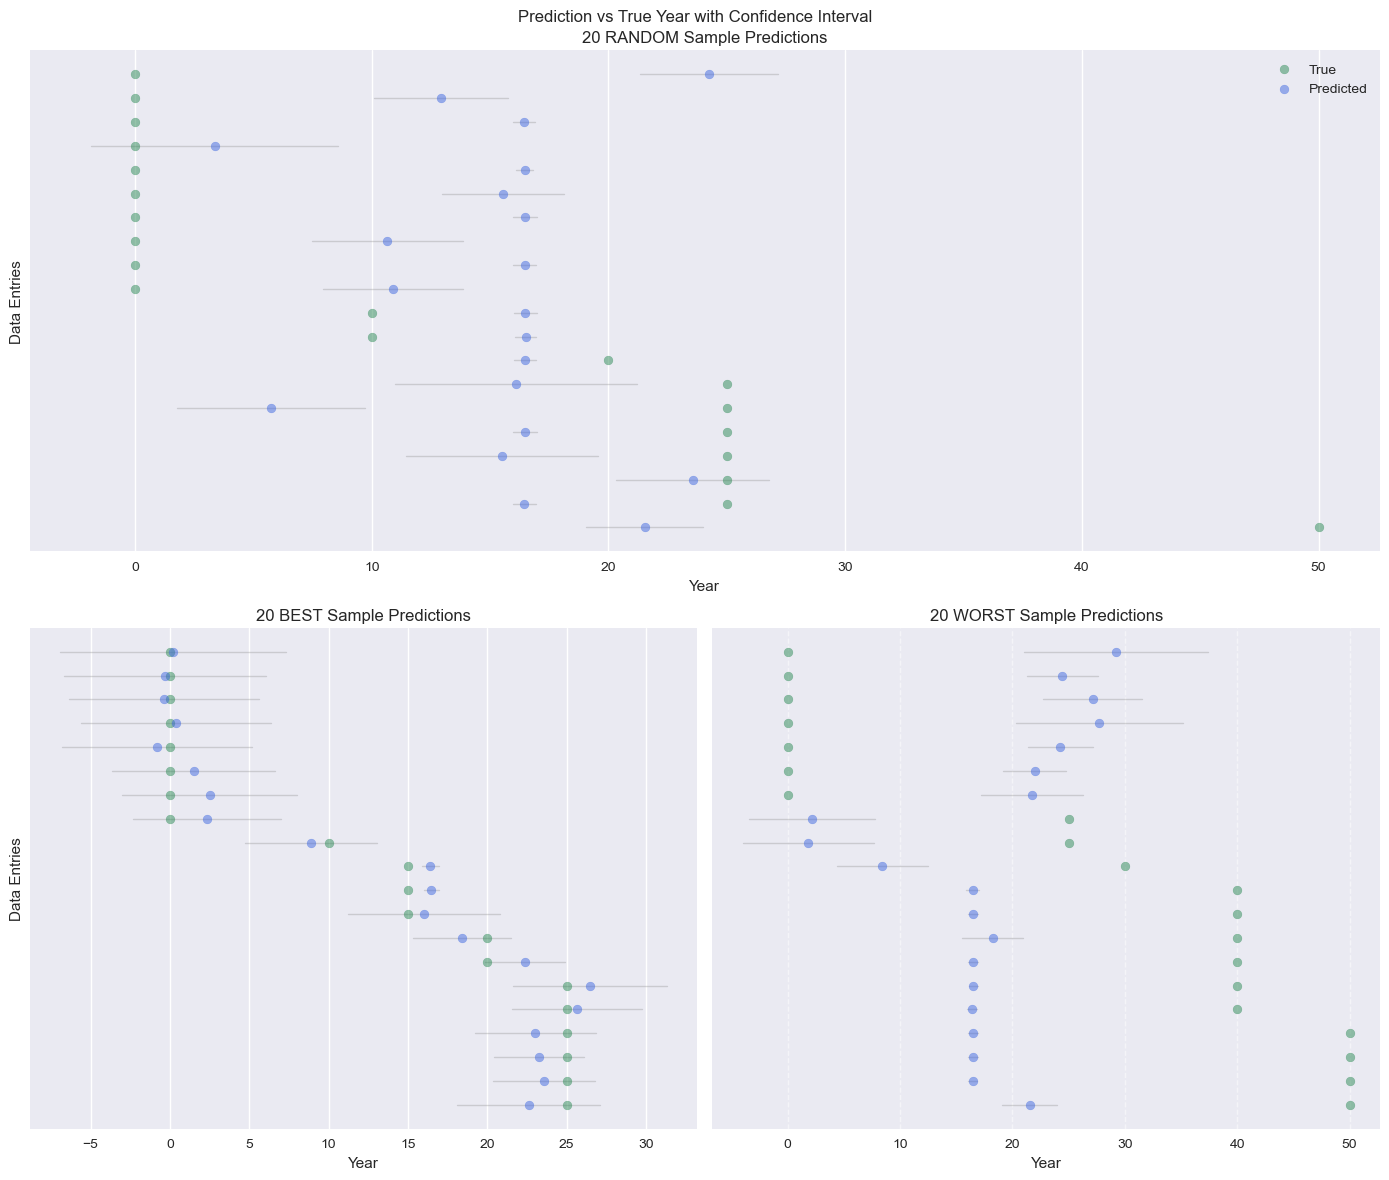

In [24]:
for t, target in enumerate(targets):
    print(f"\n\n\nTARGET: {target}")

    results = get_results_table(y["test"][:, t], y_pred[:, t], y_std[:, t])

    # Evaluate
    scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
    plot_prediction_scores(scores, "PotteryChronologyPredictor MLP", target, ft)

    # Predictions Close Look
    result_subsets = get_result_subsets(results, samples=20)
    print_top_1(result_subsets)
    plot_true_vs_pred(result_subsets)

## Text + Image Combo Input MLP Model

### Build Model

In [25]:
fts = ["tfidf", "vit"]
ft = " + ".join(fts)
params = best_params[ft]["params"]
pd.Series(params, name="value")

activation                   relu
blocks                          1
dropout                       0.2
hidden_size                   512
hidden_size_pattern    decreasing
lr                          0.005
Name: value, dtype: object

In [26]:
model_cmb = PotteryChronologyPredictor(
    [X_dim[_ft] for _ft in fts],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="years"
)

model_img.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 768]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 768]                  [1, 64]                   --                        --
│    │    └─Linear: 3-1                  [1, 768]                  [1, 64]                   49,216                    49,216
│    │    └─GELU: 3-2                    [1, 64]                   [1, 64]                   --                        --
│    │    └─Dropout: 3-3                 [1, 64]                   [1, 64]                   --                        --
├─Sequential: 1-2                        [1, 64]                   [1, 2]                    --                        --
│    └─Linear

### Load Weights

In [27]:
path_model = os.path.join(path_models, f"pottery_chronology_predictor_{"_".join(fts)}.pt")
model_cmb.load_state_dict(torch.load(path_model, weights_only=True))
model_cmb.eval()

print(f"✅ Loaded {ft.upper()}-Input Model. Ready for testing!")

✅ Loaded TFIDF + VIT-Input Model. Ready for testing!


### Predict Test Set

In [28]:
y_pred, y_std = predict_mc(model_cmb, loaders["test"][ft], y_scaler, mc_samples=50)

[Test]: 100%|██████████| 3/3 [00:00<00:00, 56.73it/s]





TARGET: StartYear




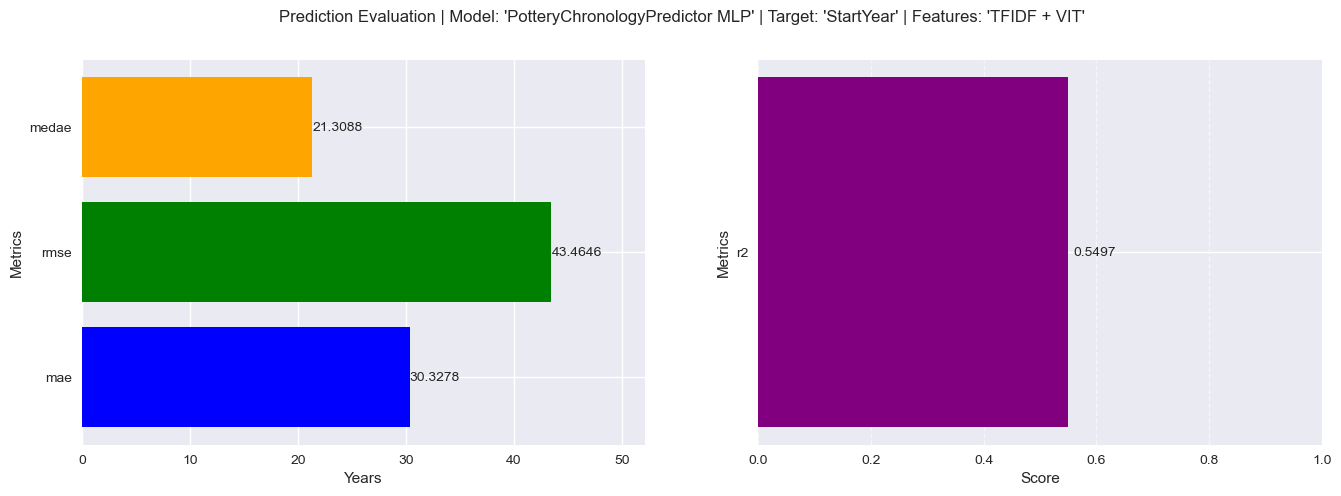



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,-400.0,-410.526733,6.707816,-423.674053,-397.379414,10.526733
65,BEST,-480.0,-480.143982,7.886336,-495.601200,-464.686764,0.143982
159,WORST,-350.0,-527.941711,9.470438,-546.503770,-509.379652,177.941711


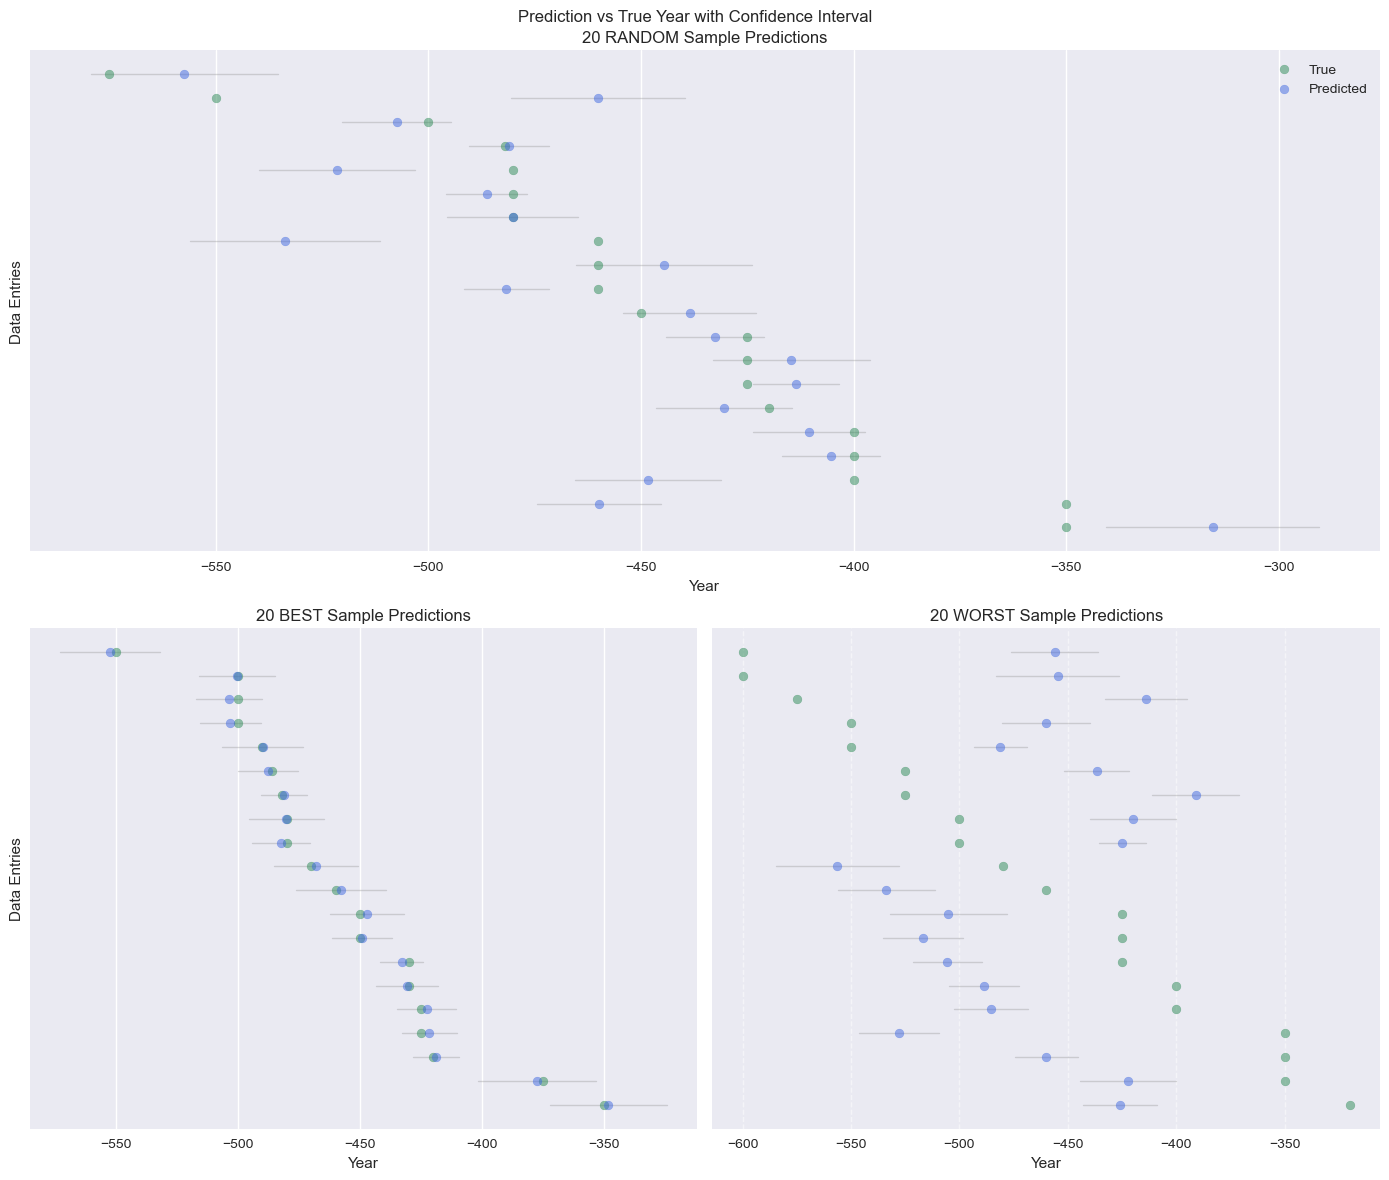




TARGET: YearRange




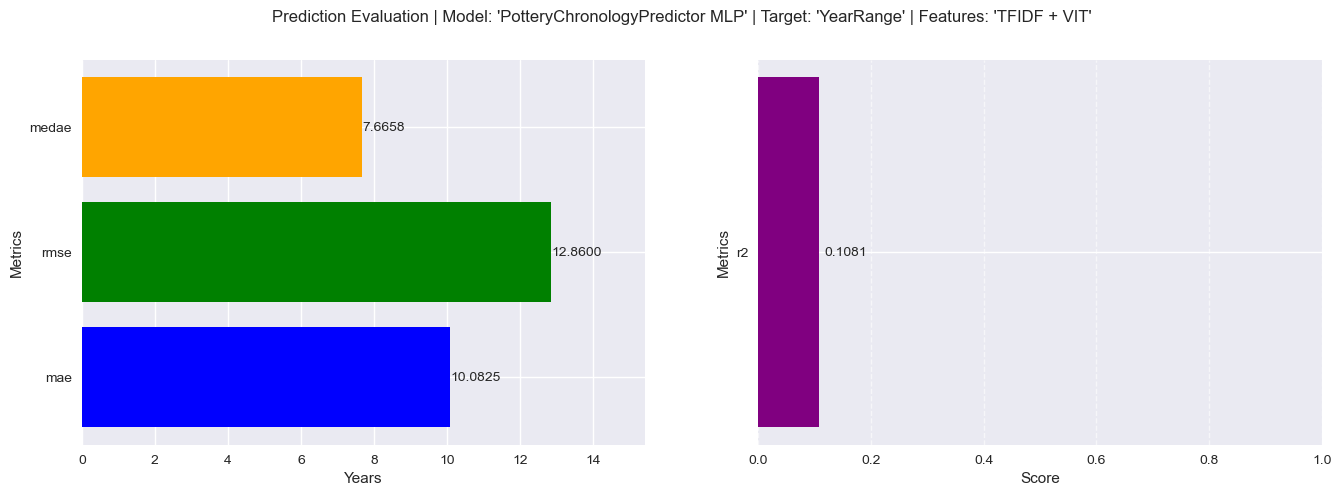



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,50.0,23.709478,2.037518,19.715943,27.703014,26.290522
158,BEST,10.0,9.623880,2.104688,5.498691,13.749069,0.376120
189,WORST,50.0,16.148901,1.193449,13.809741,18.488061,33.851099


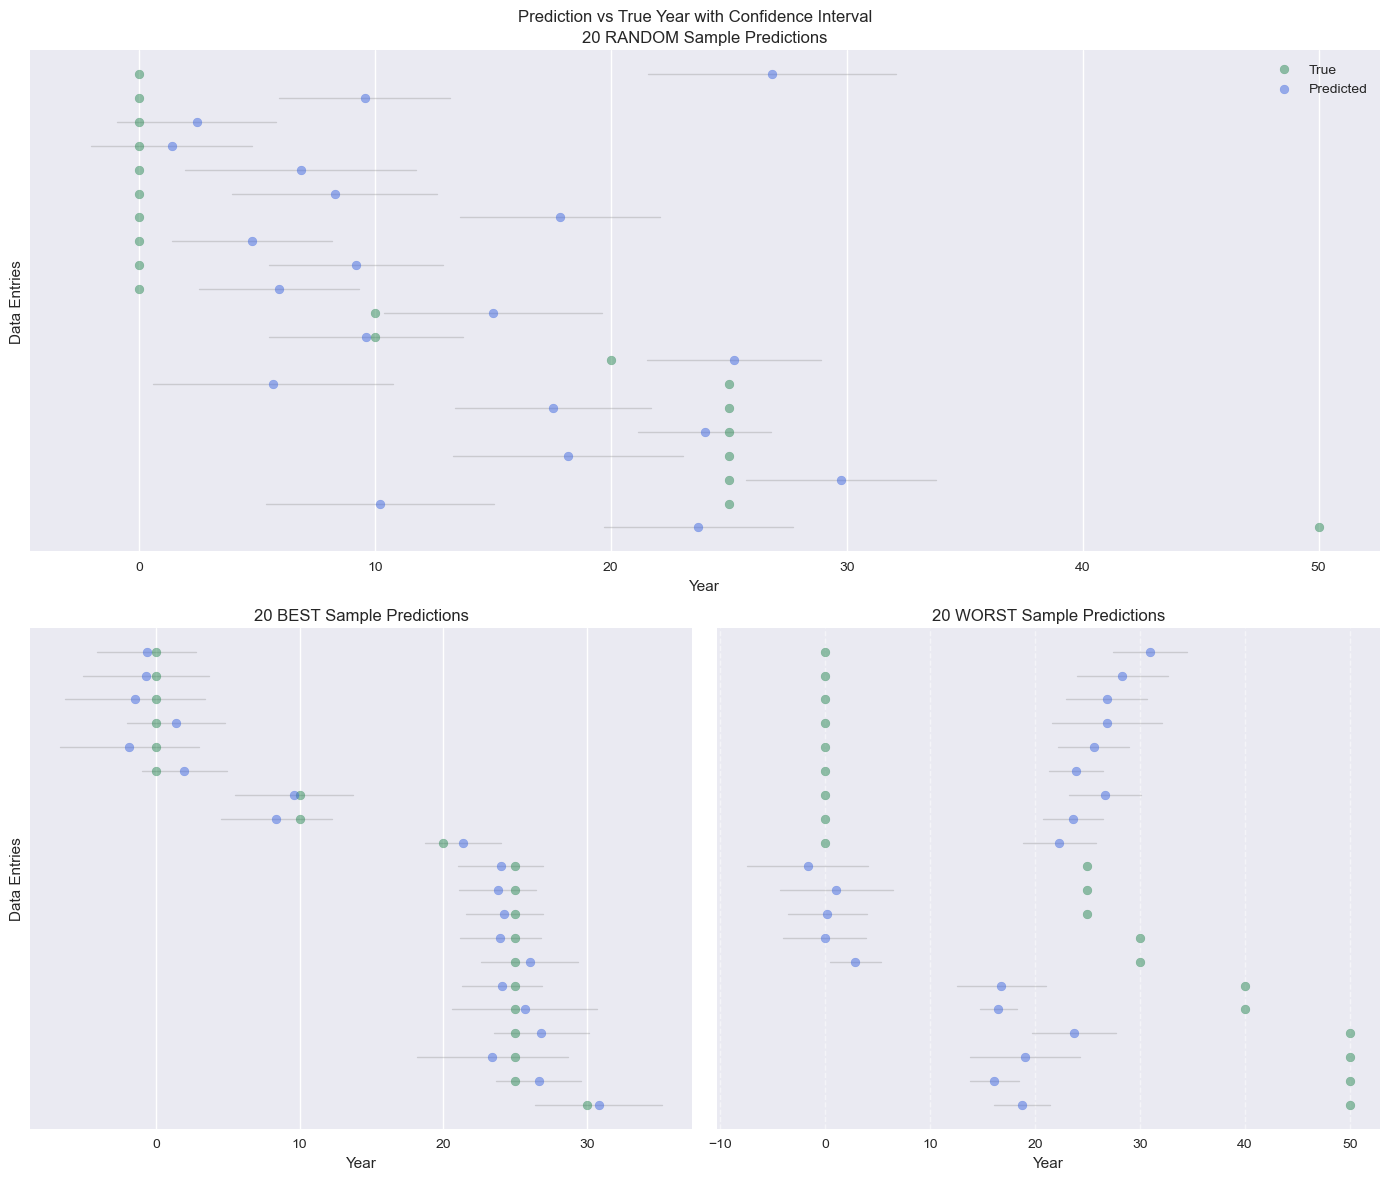

In [29]:
for t, target in enumerate(targets):
    print(f"\n\n\nTARGET: {target}")

    results = get_results_table(y["test"][:, t], y_pred[:, t], y_std[:, t])

    # Evaluate
    scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
    plot_prediction_scores(scores, "PotteryChronologyPredictor MLP", target, ft)

    # Predictions Close Look
    result_subsets = get_result_subsets(results, samples=20)
    print_top_1(result_subsets)
    plot_true_vs_pred(result_subsets)